# NumPyro and Hamiltonian Monte Carlo

In this tutorial we will see how we to integrate our ∂Lux optical models with the Probabilistic Programming Language (PPL) NumPyro. This allows us to run a subset of MCMC algorithms known as Hamiltonian Monte Carlo (HMC), which take advantage of autodiff to infer the relationship between a large number of parameters.

In this example we will simulate a binary star through a simple optical system, and simultaneously infer the stellar and optical parameters.

In [ ]:
import os  # Set CPU count for numpyro multichain multi-thread
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=4'
from jax import device_count
if device_count() != 4:
    raise ValueError("JAX/XLA is not using all 4 cores")

import jax.numpy as np
import jax.random as jr
import jax
import numpyro
from dLuxToliman import AlphaCen, TolimanOptics, Toliman  # Source & Optics
import matplotlib.pyplot as plt  # Plotting/visualisation
import numpyro as npy
import numpyro.distributions as dist

# Set global plotting parameters
%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = 'monospace'
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

Let's construct the source and optics. In this case, we will use the `AlphaCen` source from the [`dLuxToliman`](https://github.com/maxecharles/dLuxToliman) package as it gives separation in arcseconds and flux in log units. This will make our NumPyro sampling functions simpler.

In [25]:
param_list = [
    # 'x_position',
    # 'y_position',
    'separation',
    # 'position_angle',
    # 'log_flux',
    'contrast',
              ]

truths = [
    # npy.sample("x", dist.Uniform(-0.1, 0.1), rng_key=jr.PRNGKey(0)),
    # npy.sample("y",    dist.Uniform(-0.1, 0.1), rng_key=jr.PRNGKey(1)),
    npy.sample("sep",  dist.Uniform(6, 10), rng_key=jr.PRNGKey(3)),
    # npy.sample("pa",   dist.Uniform(0, 360), rng_key=jr.PRNGKey(3)),
    # npy.sample("logF", dist.Uniform(5, 8), rng_key=jr.PRNGKey(4)),
    npy.sample("cont", dist.Uniform(2, 3), rng_key=jr.PRNGKey(6)),
]

optics = TolimanOptics(psf_npixels=128, psf_oversample=1.5)
source = AlphaCen().set(param_list, truths)
telescope = Toliman(optics, source)
psf = telescope.model()

# adding noise
psf_photon = jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 3*jr.normal(jr.PRNGKey(0), psf_photon.shape)
data = psf_photon + np.abs(bg_noise)

Now, let's create simulated data and examine them.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(11,4))
c1 = ax[0].imshow(psf**.5)
ax[0].set(
    title=r'Simulated Raw $\sqrt{PSF}$',
    xlabel='x [pixels]',
    ylabel='y [pixels]',
    xticks=[0, psf.shape[0]-1],
    yticks=[0, psf.shape[0]-1],
)
fig.colorbar(c1, label='Sqrt Counts')

c2 = ax[1].imshow(data**.5)
ax[1].set(
    title=r'Simulated Data',
    xlabel='x [pixels]',
    ylabel='y [pixels]',
    xticks=[0, data.shape[0]-1],
    yticks=[0, data.shape[0]-1],
)
fig.colorbar(c2, label='Sqrt Counts')
plt.show()

---

# Inference with NumPyro

Awesome, now we are going to try and infer these parameters using HMC. There are quite a few different parameters we want to infer:

##  Source Parameters
 - The $(x,y)$ mean position (2 parameters)
 - The binary separation (1 parameter)
 - The position angle (1 parameter)
 - The mean flux (1 parameter)
 - The contrast ratio (1 parameter)
 
## Optical Parameters
 - The Zernike aberration coefficients (7 parameters)
 
This gives us a total of 13 parameters, which is quite high dimensional for regular MCMC algorithms.

Next, we construct our NumPyro sampling function. In this function we need to define prior distribution variables for our parameters, along with the corresponding parameter path. This allows for NumPyro to simultaneously sample the posterior of all parameters by taking advantage of the differentiable nature of these models.

With these parameters, we create a `plate` which defines our data. We use a Poisson likelihood since photon noise is our dominant noise source.

In [22]:
def psf_model(data, model):
    """
    Define the numpyro function
    """
    values = [
        # npy.sample("x",        dist.Uniform(-0.1, 0.1)),
        # npy.sample("y",        dist.Uniform(-0.1, 0.1)),
        npy.sample("sep",      dist.Uniform(0.5, 10)),
        # npy.sample("pa",       dist.Uniform(0, 360)),
        # npy.sample("log_flux", dist.Uniform(5, 8)),
        npy.sample("contrast", dist.Uniform(1, 5)),
    ]

    with npy.plate("data", len(data.flatten())):
        poisson_model = dist.Poisson(
            model.set(param_list, values).model().flatten())
        return npy.sample("psf", poisson_model, obs=data.flatten())

Using the model above, we can now sample from the posterior distribution using the No U-Turn Sampler (NUTS).

In [7]:
sampler = npy.infer.MCMC(
    npy.infer.NUTS(psf_model),
    num_warmup=2000,
    num_samples=4000,
    num_chains=device_count(),
    progress_bar=True,
)
sampler.run(jr.PRNGKey(0), data, telescope)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 44min 15s, sys: 2min 6s, total: 46min 21s
Wall time: 7min 17s


Let's examine the summary. Note: here we want to make sure that all the `r_hat` values are $\sim1$.

In [8]:
sampler.print_summary()
values_out = sampler.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
       sep      6.27      1.72      6.26      4.54      8.00      2.00    326.65

Number of divergences: 0


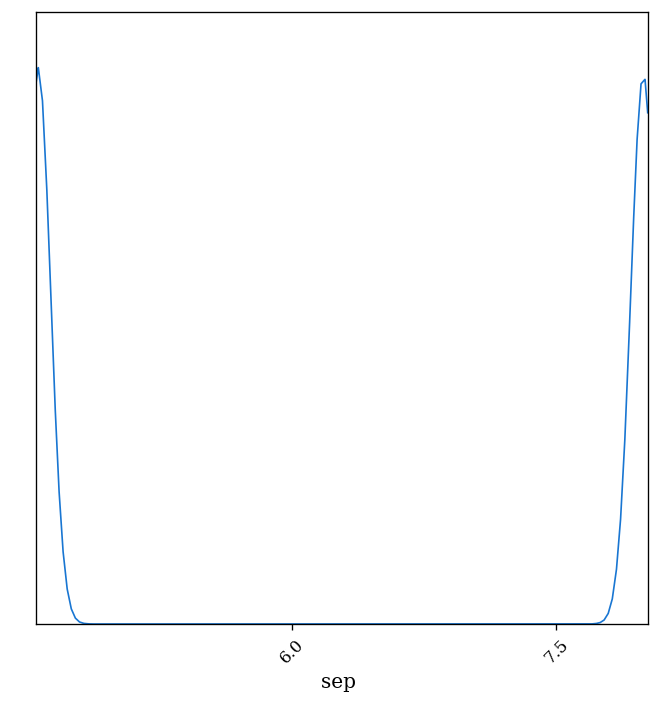

In [9]:
import chainconsumer as cc

chain = cc.ChainConsumer()
chain.add_chain(values_out)#, parameters=param_list, name="Recovered Parameters")
chain.configure(serif=True, shade=True, bar_shade=True, shade_alpha=0.2, spacing=1., max_ticks=3)
chain.configure_truth(color='w', ls=":", alpha=0.8)
fig = chain.plotter.plot(truth=truths)
fig.set_size_inches((6,6))

Excellent! All the parameters are well constrained.